# DS7333 Case Study 1
## Predicting the Critical Temperature of Various Superconductors Utilizing Regression Models

#### John Girard, Shijo Joseph, Douglas Yip

#### Objective

We have been tasked with creating a linear regression model to predict critical temperature of various super conductors.  We will also examine which variables are most important in our model.

In [46]:
# Importing Libraries that will be used to ingest data and complete our regression
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

import seaborn as sns
import plotly.express as px

from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso, LinearRegression, Ridge, RidgeCV, LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statistics import mean

## 1) Import and Check data
This process will ingest the data into one dataframe and will validate integrity of data before proceeding to EDA

In [21]:
#Import data
df1 = pd.read_csv('https://raw.githubusercontent.com/dk28yip/MSDS7333/main/unique_m.csv')
df2 = pd.read_csv('https://raw.githubusercontent.com/dk28yip/MSDS7333/main/train.csv')

#drop critical temp since column exist in both sets
df1 = df1.drop(['critical_temp'], axis=1)

# Merge the two data frames
df = pd.concat([df1, df2], axis=1)

In [27]:
#check dataframe
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Columns: 169 entries, H to critical_temp
dtypes: float64(156), int64(12), object(1)
memory usage: 27.4+ MB


H  He   Li   Be    B    C    N    O    F  Ne  ...  wtd_mean_Valence  \
0  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...          2.257143   
1  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...          2.257143   
2  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...          2.271429   
3  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...          2.264286   
4  0.0   0  0.0  0.0  0.0  0.0  0.0  4.0  0.0   0  ...          2.242857   

   gmean_Valence  wtd_gmean_Valence  entropy_Valence  wtd_entropy_Valence  \
0       2.213364           2.219783         1.368922             1.066221   
1       1.888175           2.210679         1.557113             1.047221   
2       2.213364           2.232679         1.368922             1.029175   
3       2.213364           2.226222         1.368922             1.048834   
4       2.213364           2.206963         1.368922             1.096052   

   range_Valence  wtd_range_Valence  std_Valence  wtd_std_Valence  \
0              1           1.085714     0.433013         0.437059   
1              2           1.128571     0.632456         0.468606   
2              1           1.114286     0.433013         0.444697   
3              1           1.100000     0.433013         0.440952   
4              1           1.057143     0.433013         0.428809   

   critical_temp  
0           29.0  
1           26.0  
2           19.0  
3           22.0  
4           23.0  

[5 rows x 169 columns]

In [28]:
#Examine the shape of the data
df.shape

(21263, 169)

#### Dropped material column due to redudancy of data given that the invididual elements are showing in the data.  

In [29]:
df = df.drop(['material'], axis = 1)

In [30]:
# Any missing values in the dataset
def plot_missingness(df: pd.DataFrame=df) -> None:
    nan_df = pd.DataFrame(df.isna().sum()).reset_index()
    nan_df.columns  = ['Column', 'NaN_Count']
    nan_df['NaN_Count'] = nan_df['NaN_Count'].astype('int')
    nan_df['NaN_%'] = round(nan_df['NaN_Count']/df.shape[0] * 100,1)
    nan_df['Type']  = 'Missingness'
    nan_df.sort_values('NaN_%', inplace=True)

    # Add completeness
    for i in range(nan_df.shape[0]):
        complete_df = pd.DataFrame([nan_df.loc[i,'Column'],df.shape[0] - nan_df.loc[i,'NaN_Count'],100 - nan_df.loc[i,'NaN_%'], 'Completeness']).T
        complete_df.columns  = ['Column','NaN_Count','NaN_%','Type']
        complete_df['NaN_%'] = complete_df['NaN_%'].astype('int')
        complete_df['NaN_Count'] = complete_df['NaN_Count'].astype('int')
        nan_df = pd.concat([nan_df,complete_df], sort=True)
            
    nan_df = nan_df.rename(columns={"Column": "Feature", "NaN_%": "Missing %"})

    # Missingness Plot
    fig = px.bar(nan_df,
                 x='Feature',
                 y='Missing %',
                 title=f"Missingness Plot (N={df.shape[0]})",
                 color='Type',
                 opacity = 0.6,
                 color_discrete_sequence=['red','#808080'],
                 width=800,
                 height=400)
    fig.show()

plot_missingness(df)

#### Based on our missing NA check, there are no NAs in the data.

<AxesSubplot:>

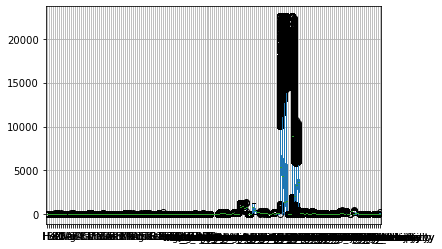

In [34]:
# look at boxplot
df.boxplot()

## 2) Scale data
Given that the box plot shows a wide range of variance between columns we will scale the data

In [35]:
#Create the response and dependent variable sets
X = df.drop(labels=['critical_temp'], axis = 1)
y = df.critical_temp


scaler = StandardScaler() #Create the standard scaler object
X_scaled = scaler.fit_transform(X) #Fit the data and transform it, leaving an array
X_scaled = pd.DataFrame(data=X_scaled, columns = X.columns) #Recreate the dataframe 

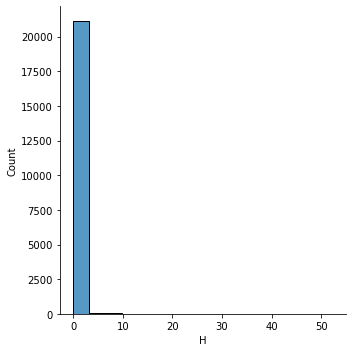

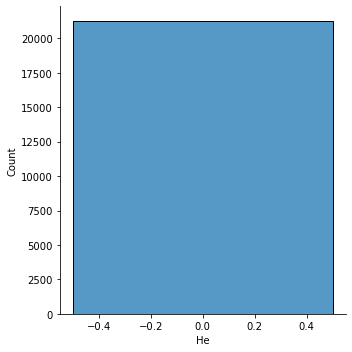

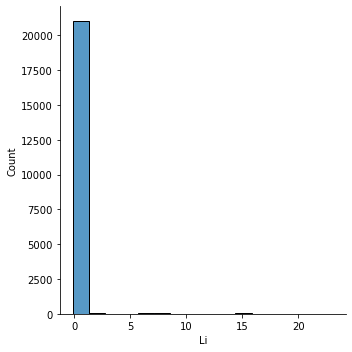

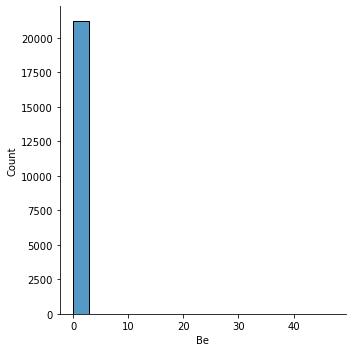

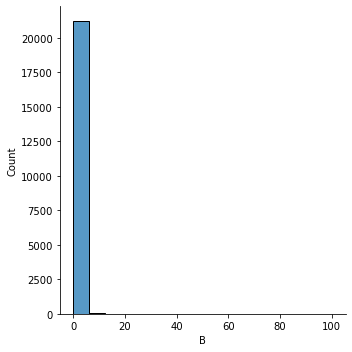

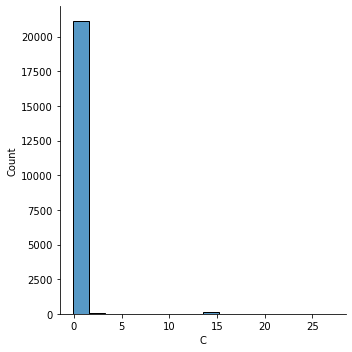

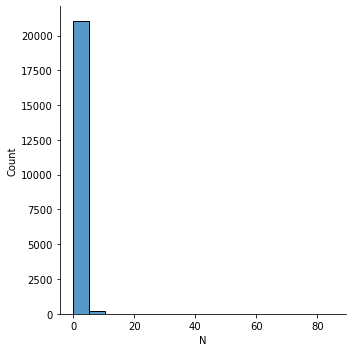

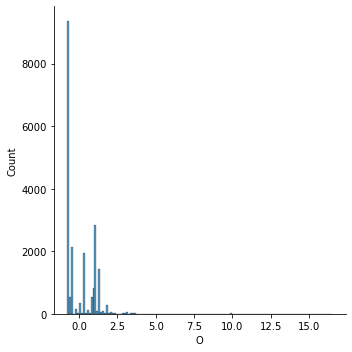

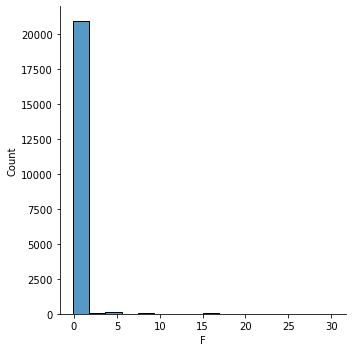

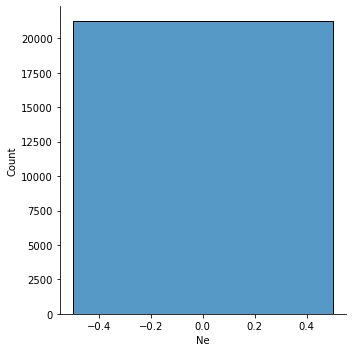

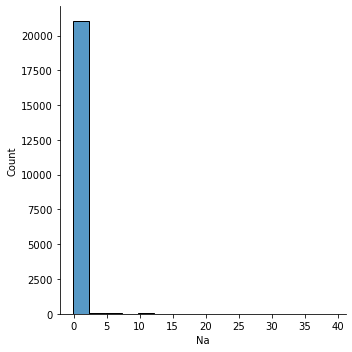

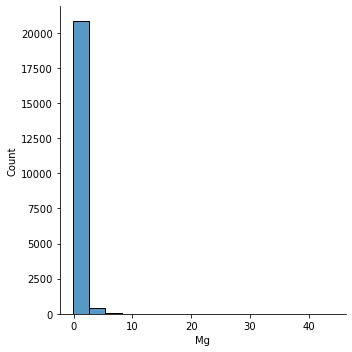

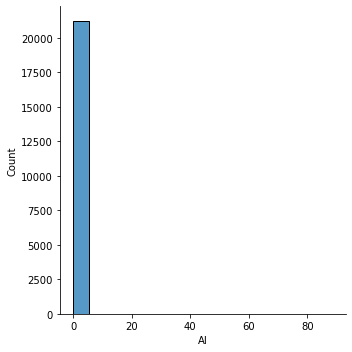

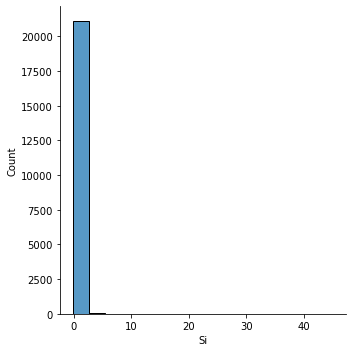

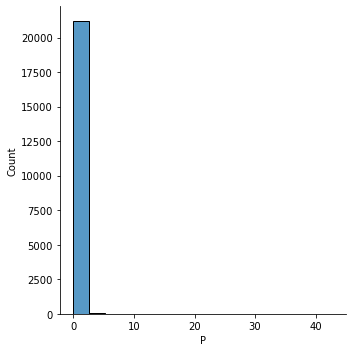

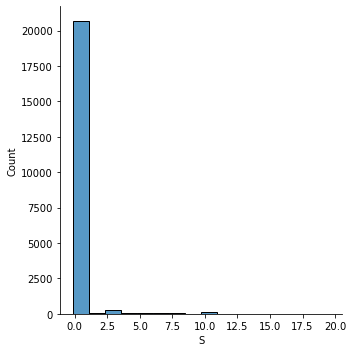

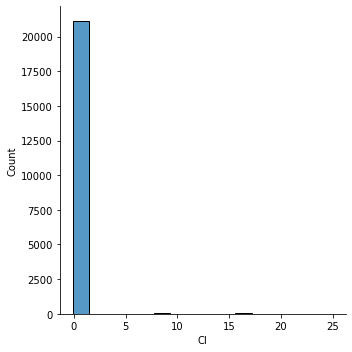

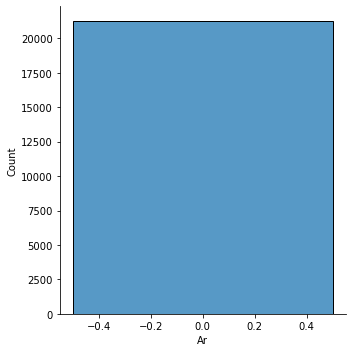

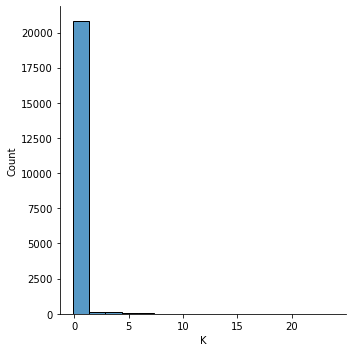

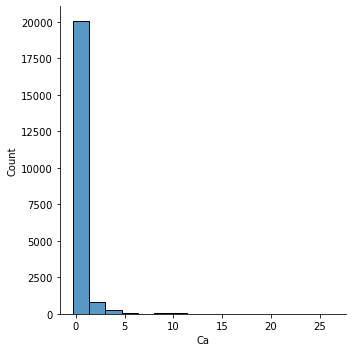

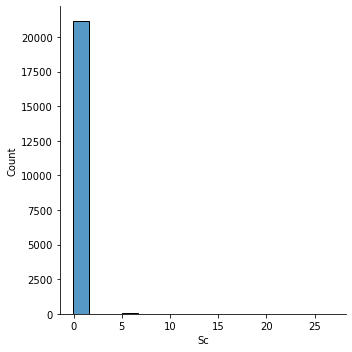

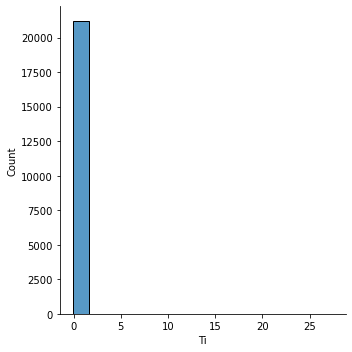

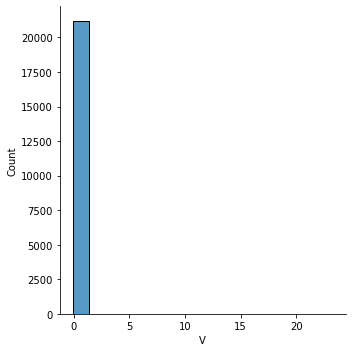

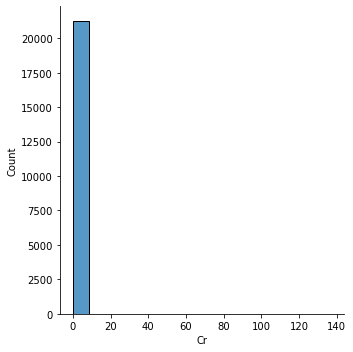

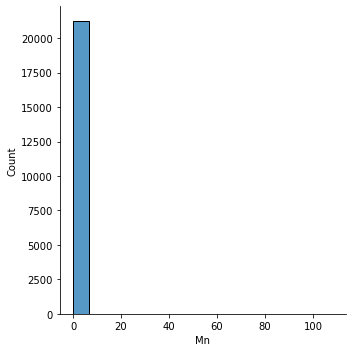

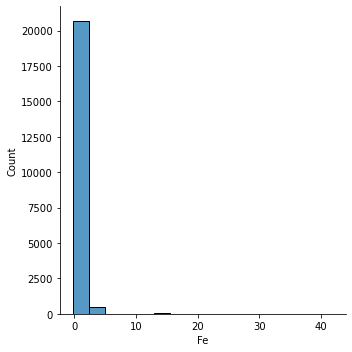

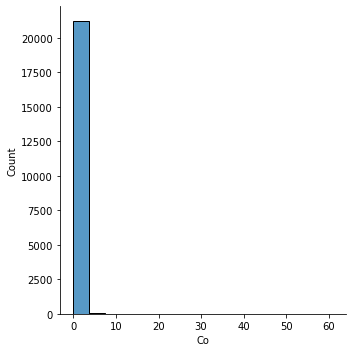

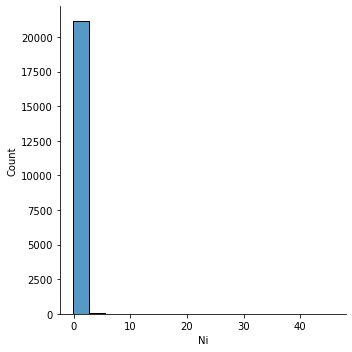

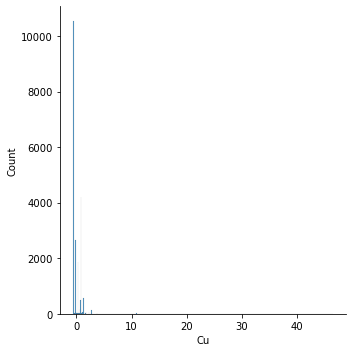

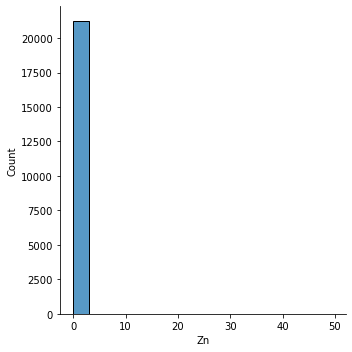

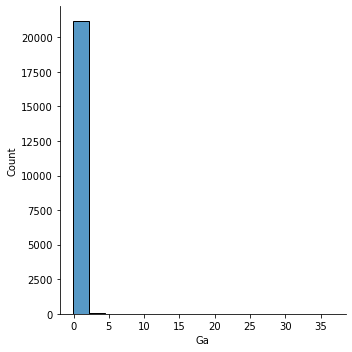

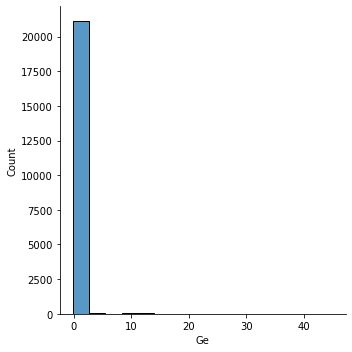

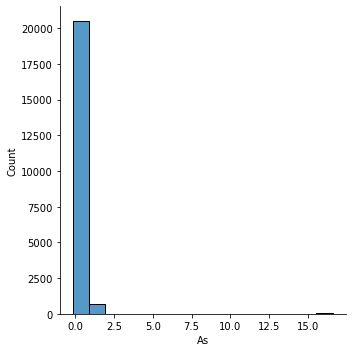

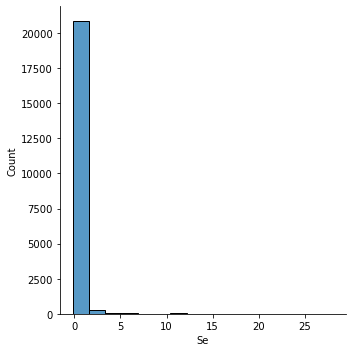

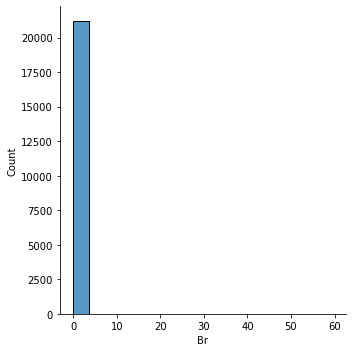

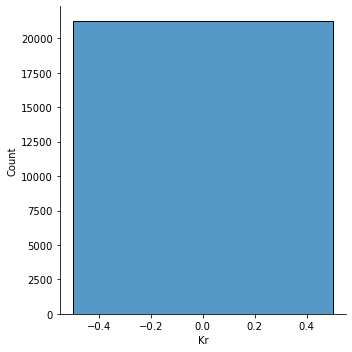

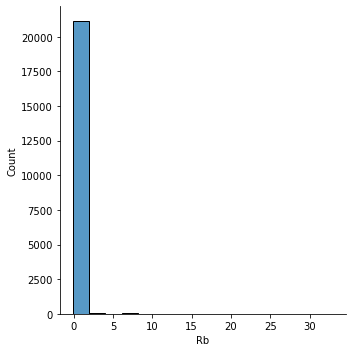

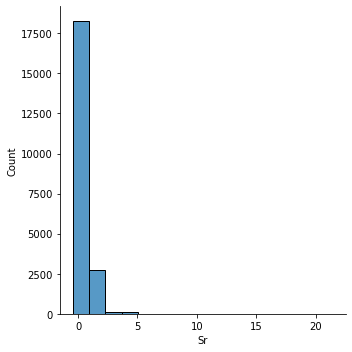

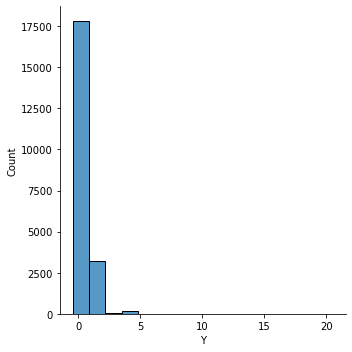

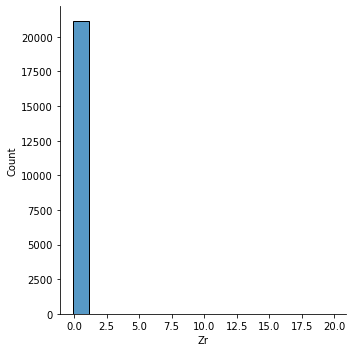

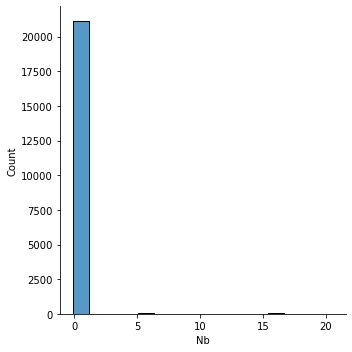

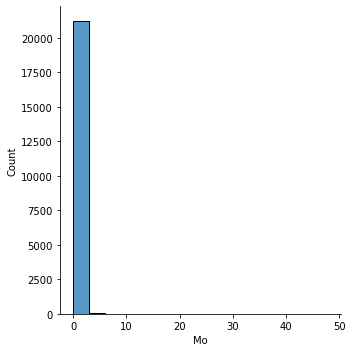

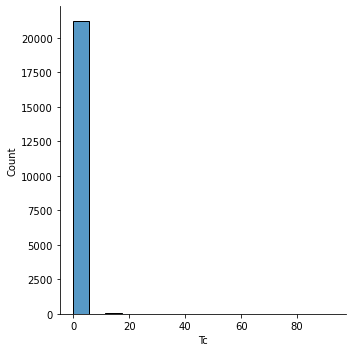

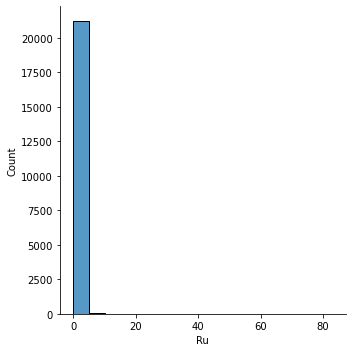

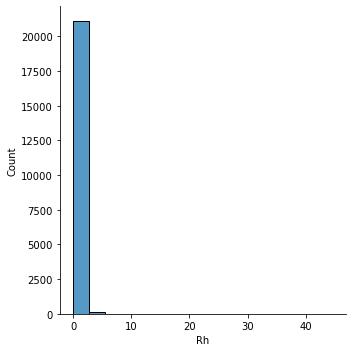

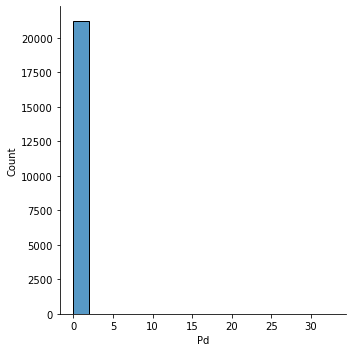

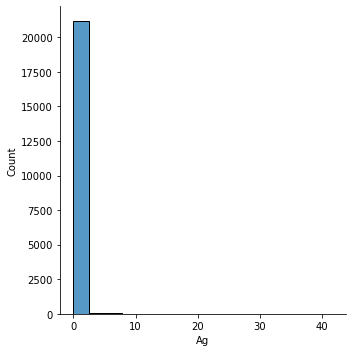

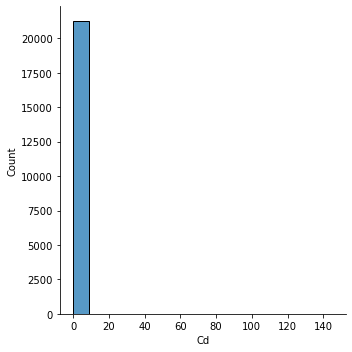

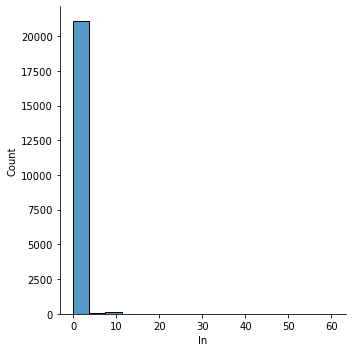

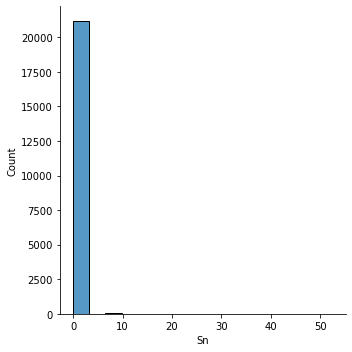

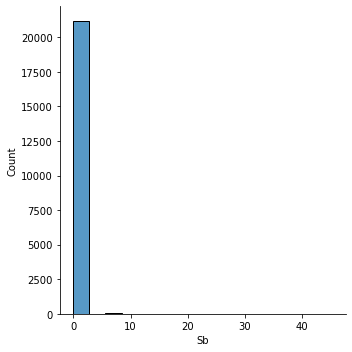

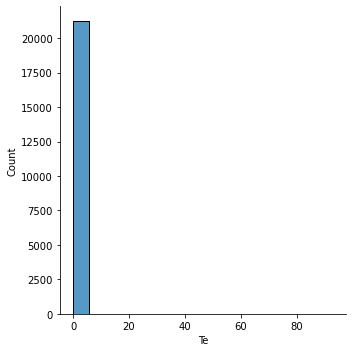

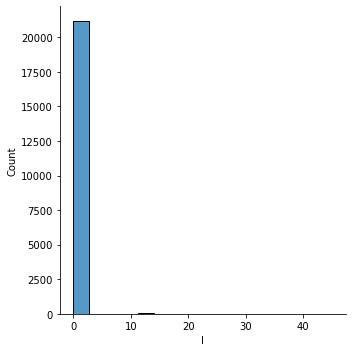

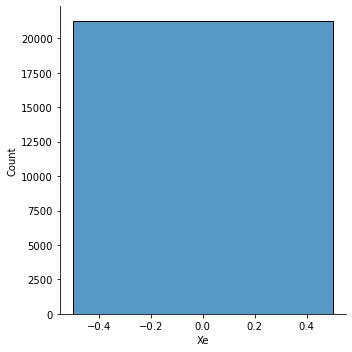

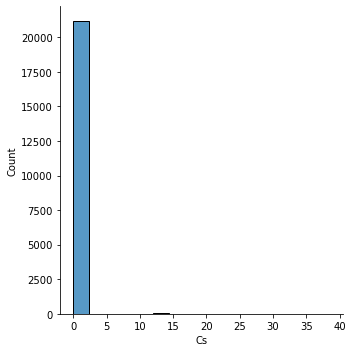

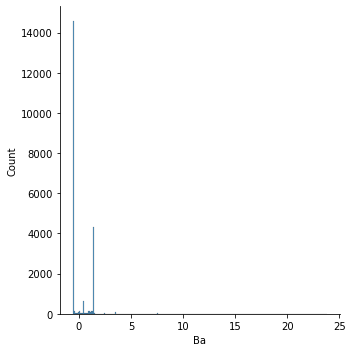

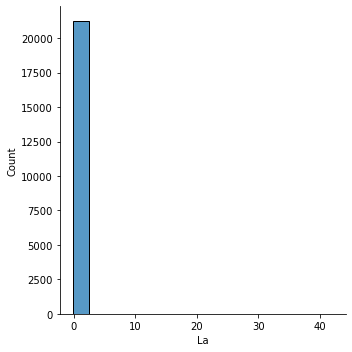

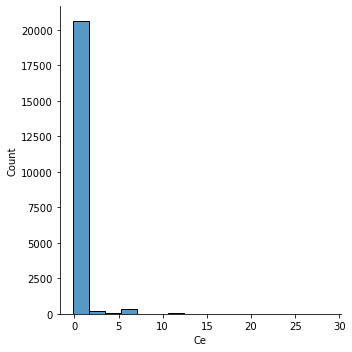

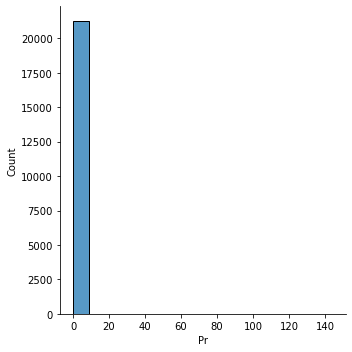

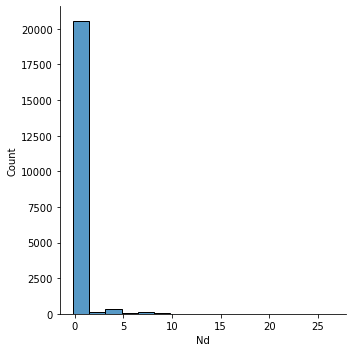

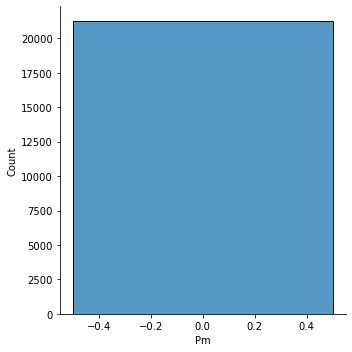

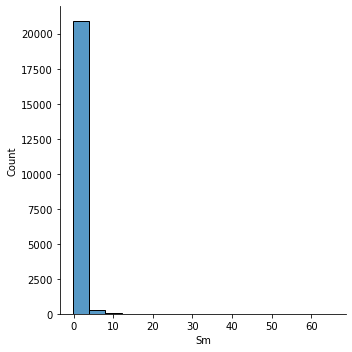

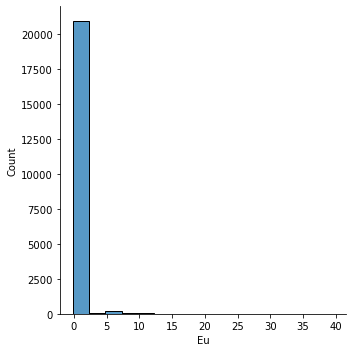

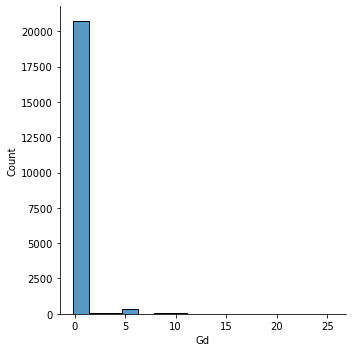

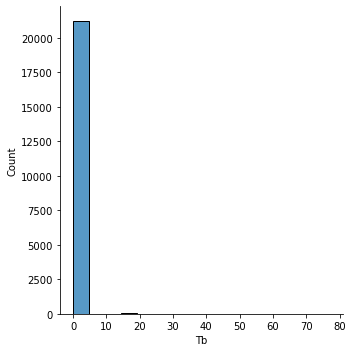

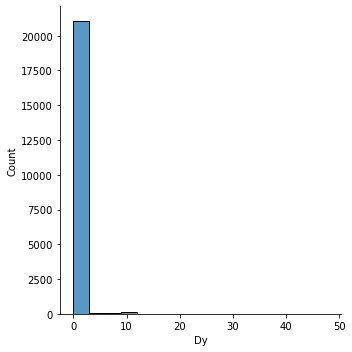

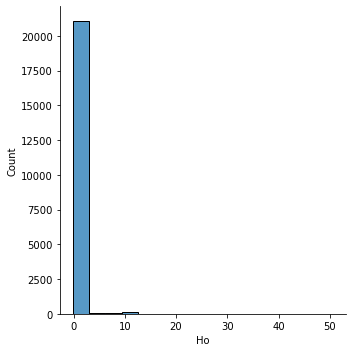

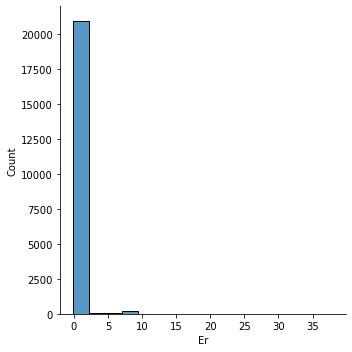

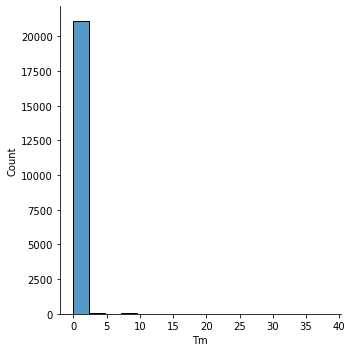

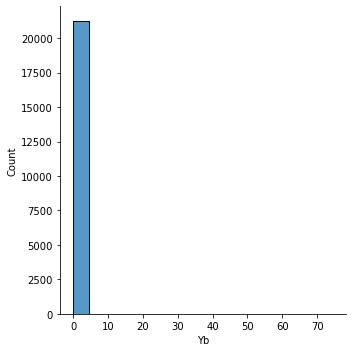

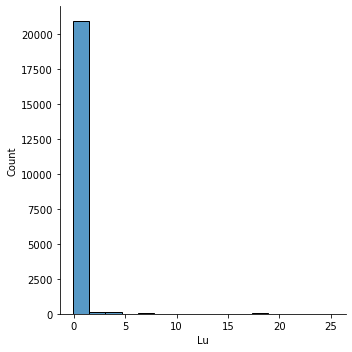

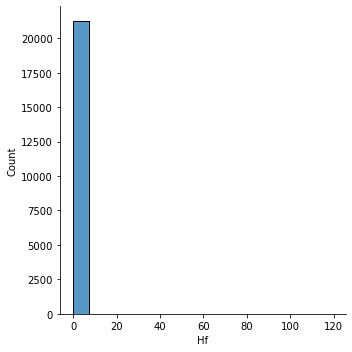

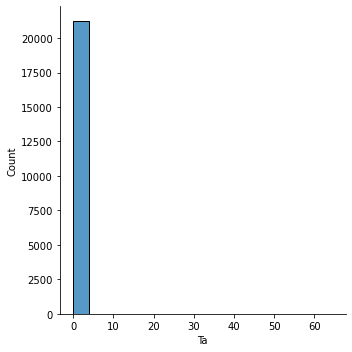

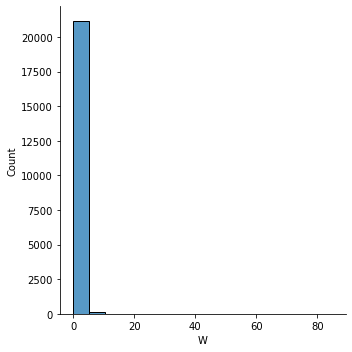

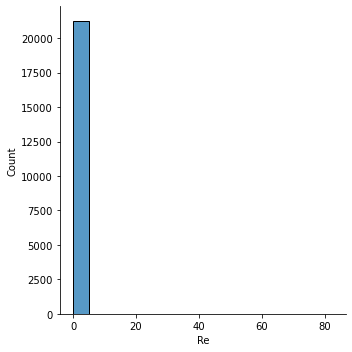

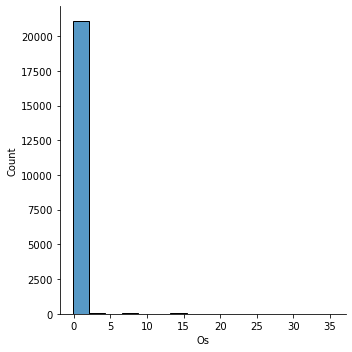

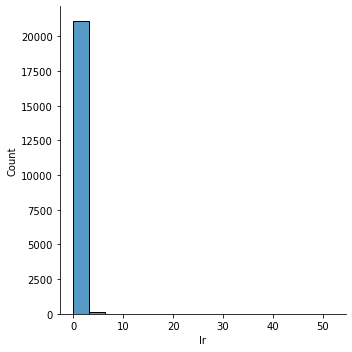

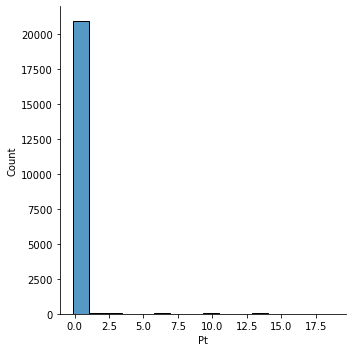

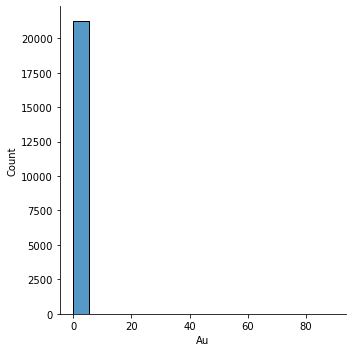

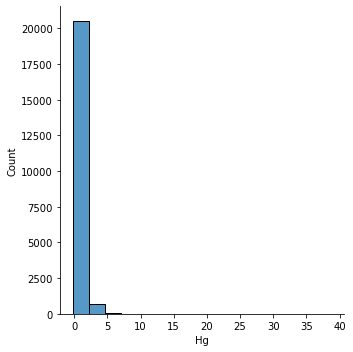

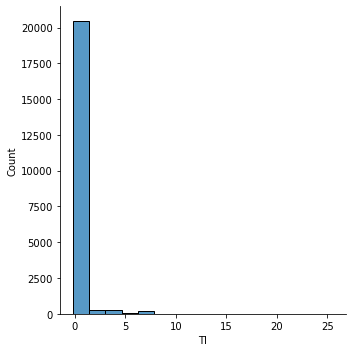

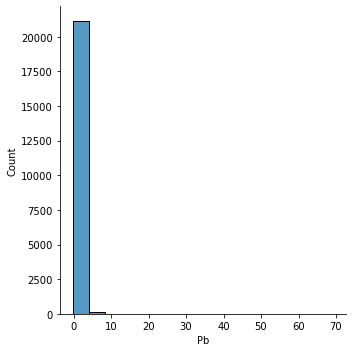

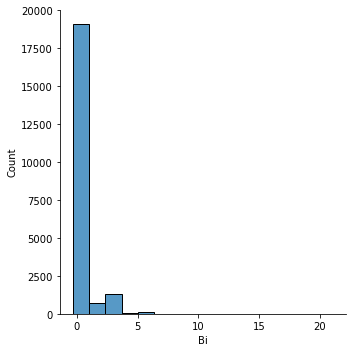

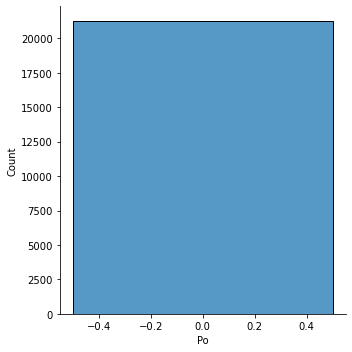

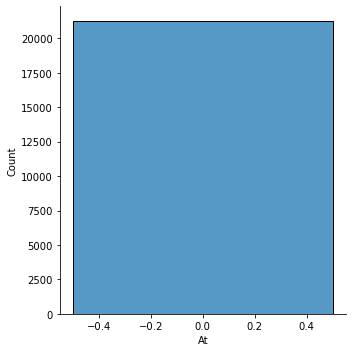

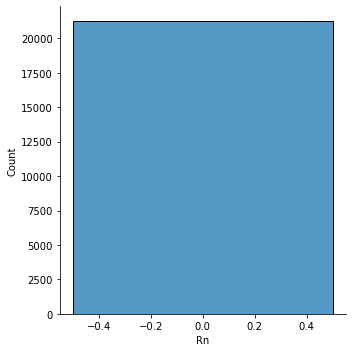

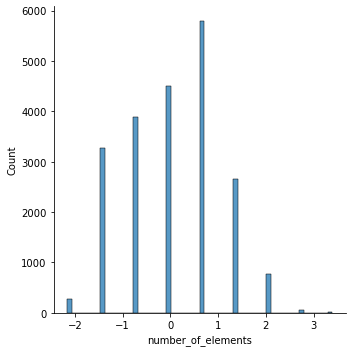

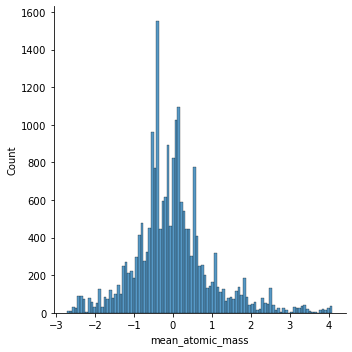

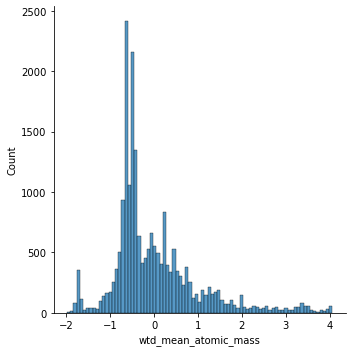

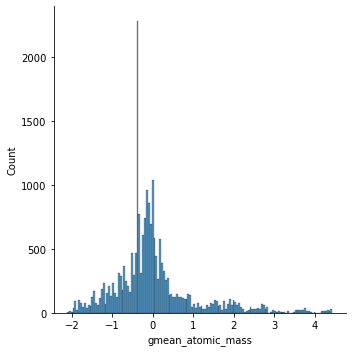

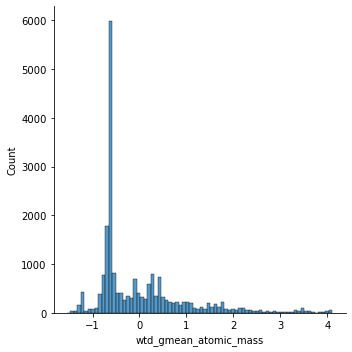

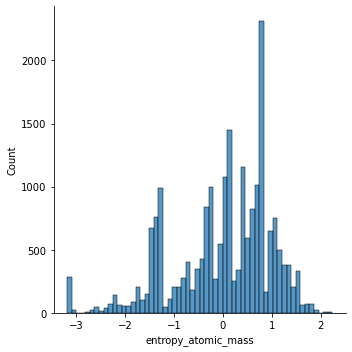

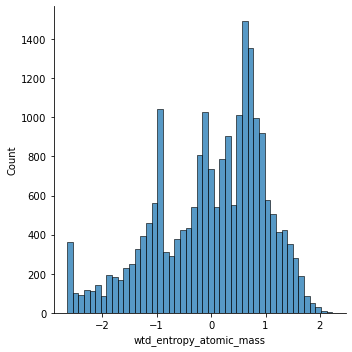

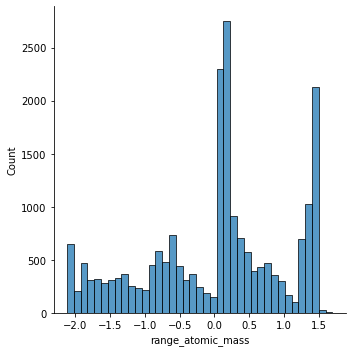

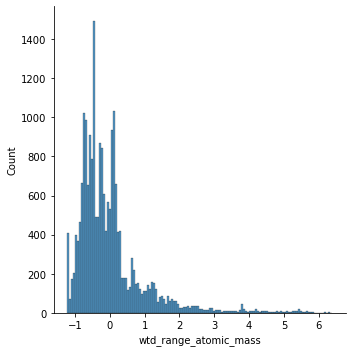

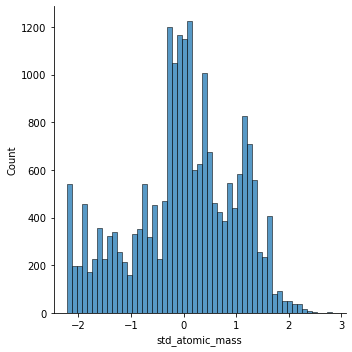

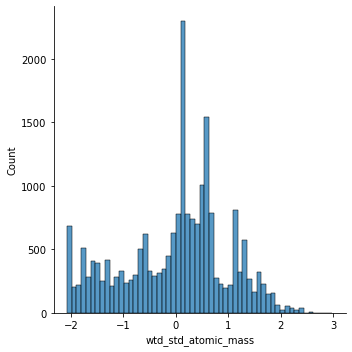

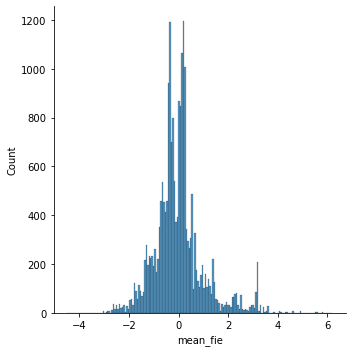

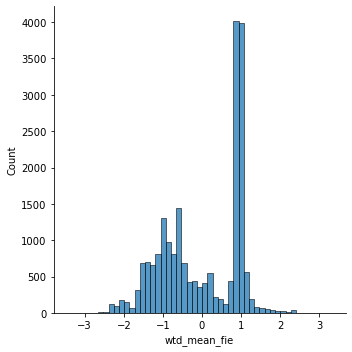

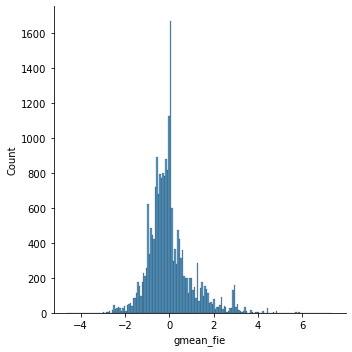

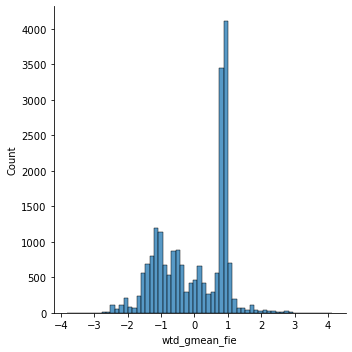

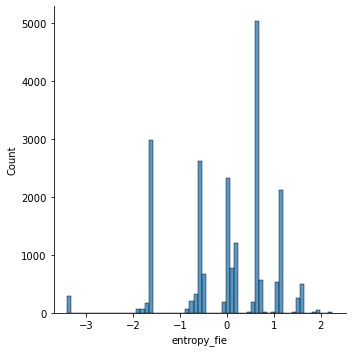

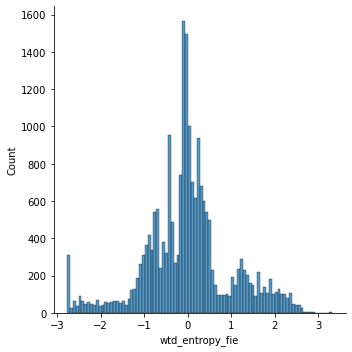

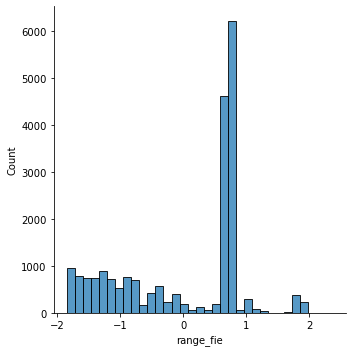

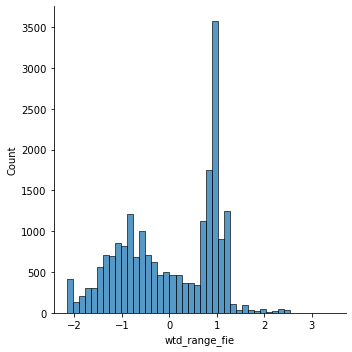

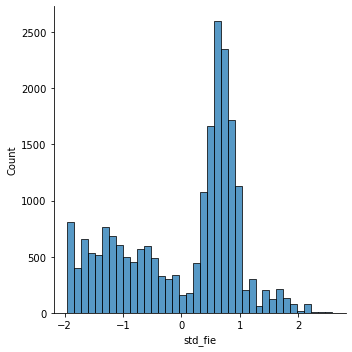

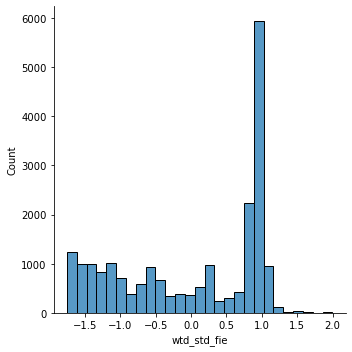

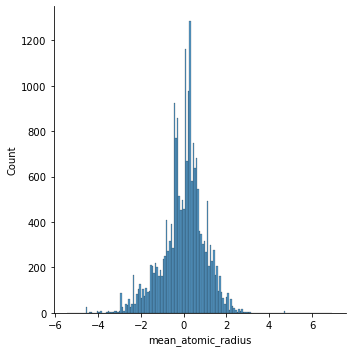

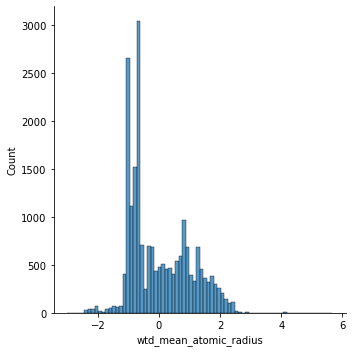

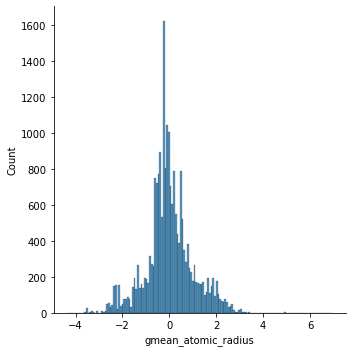

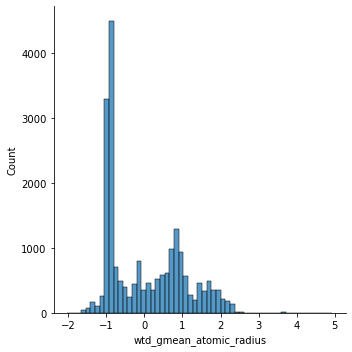

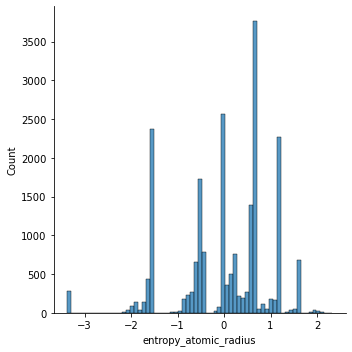

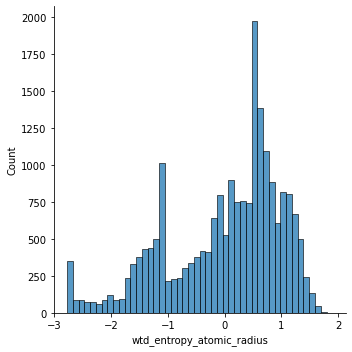

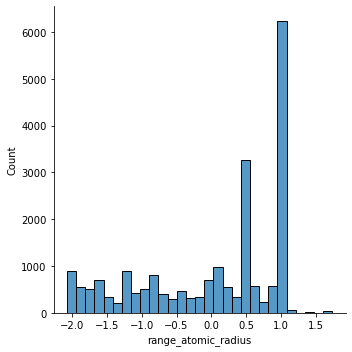

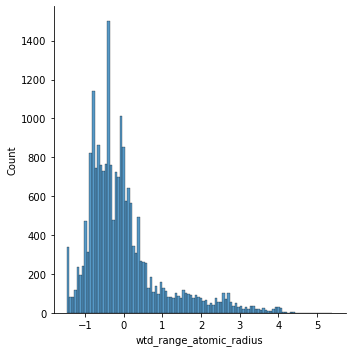

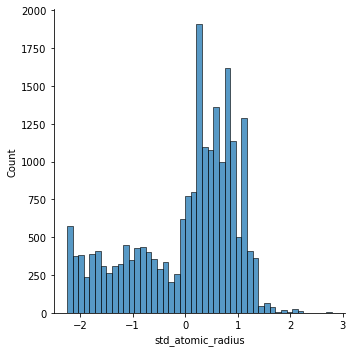

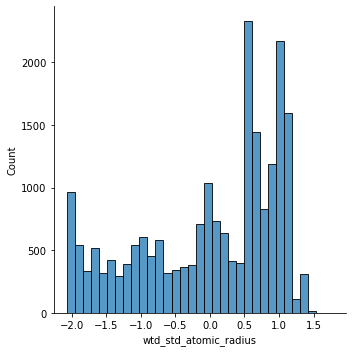

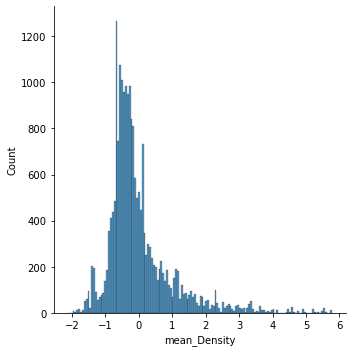

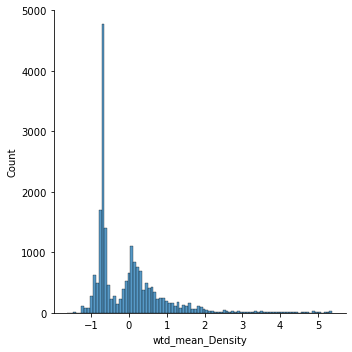

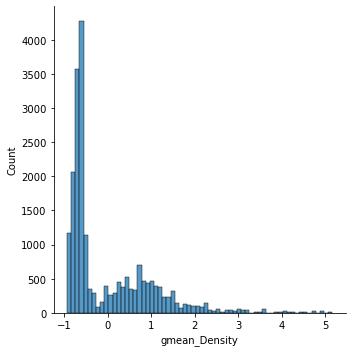

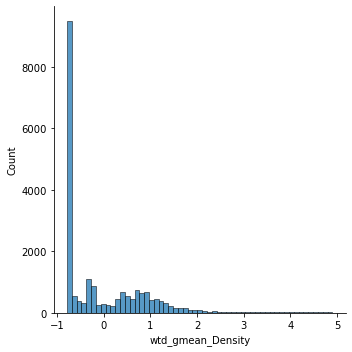

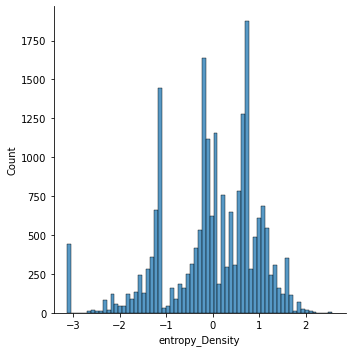

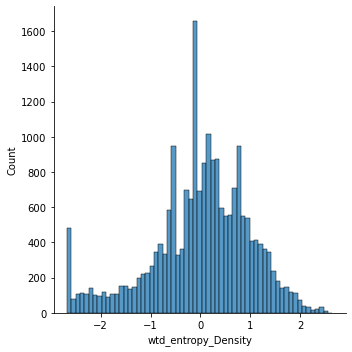

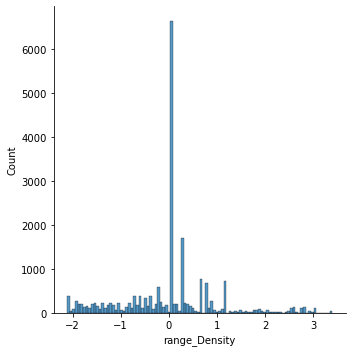

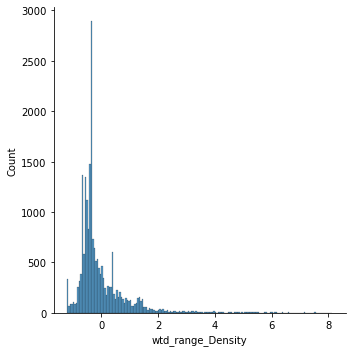

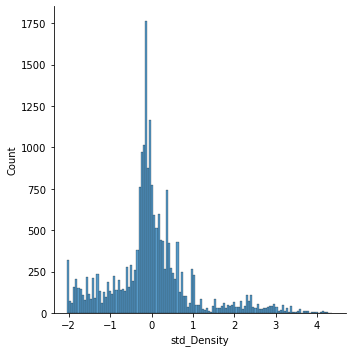

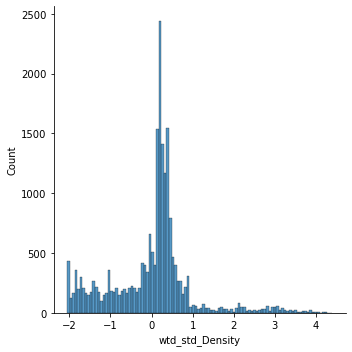

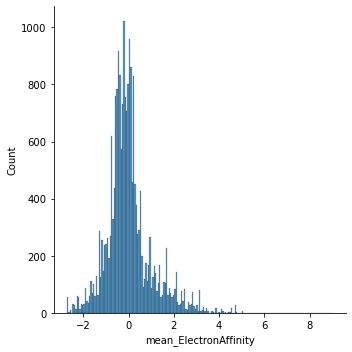

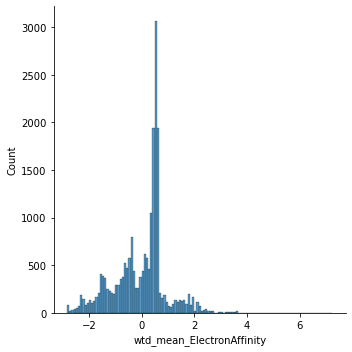

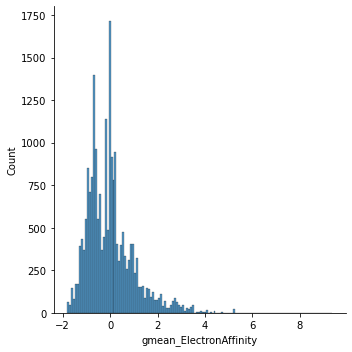

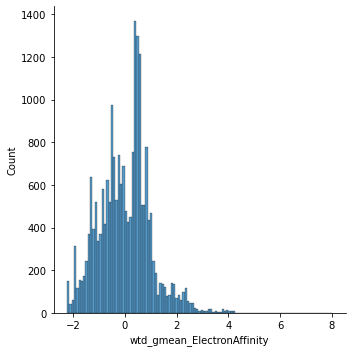

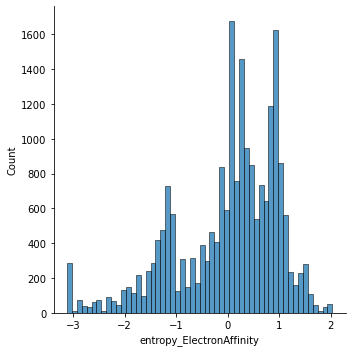

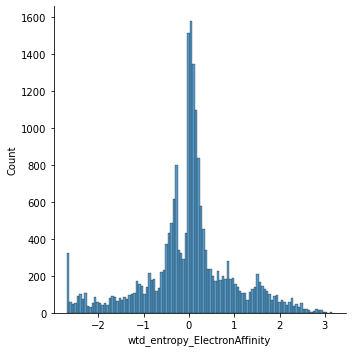

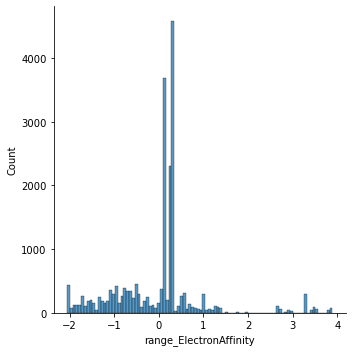

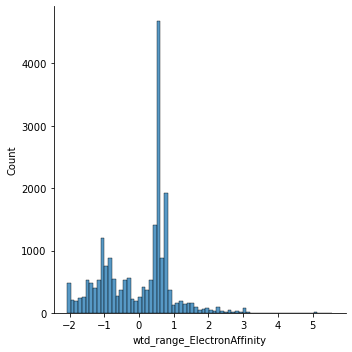

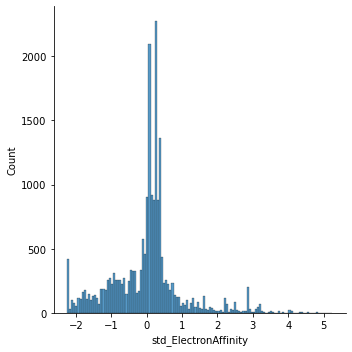

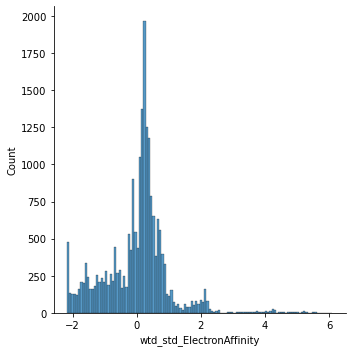

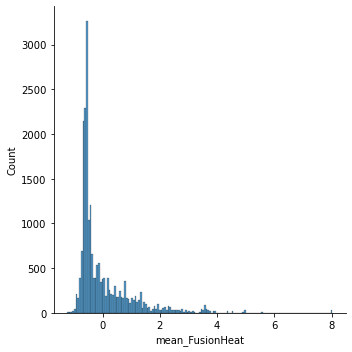

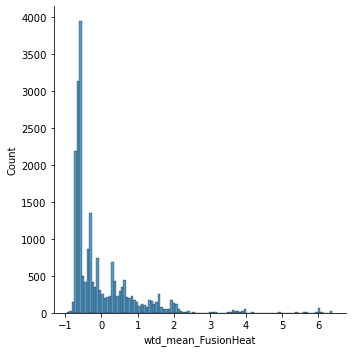

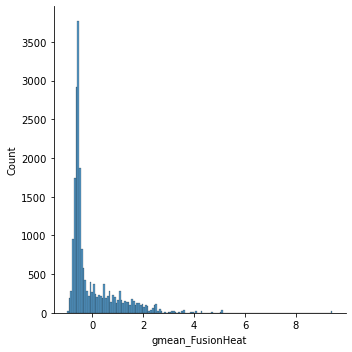

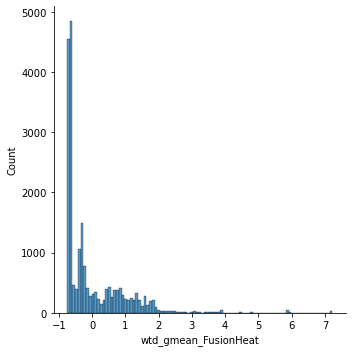

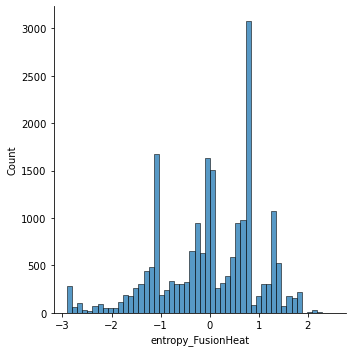

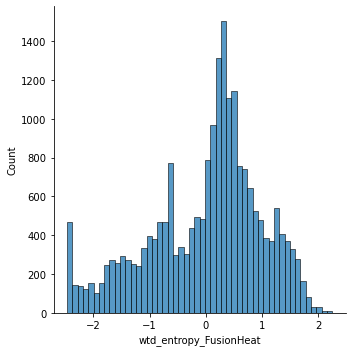

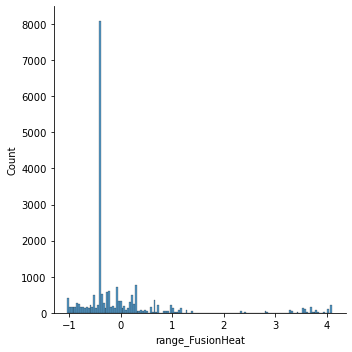

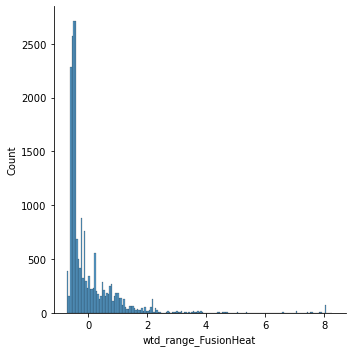

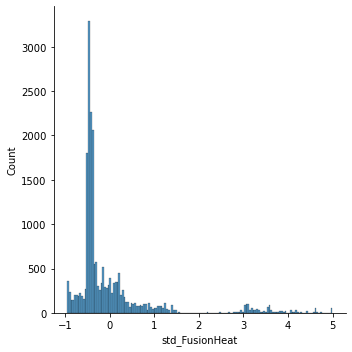

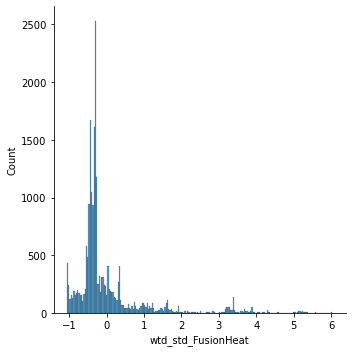

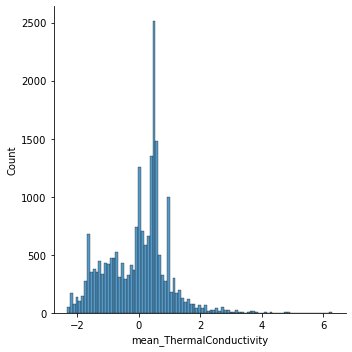

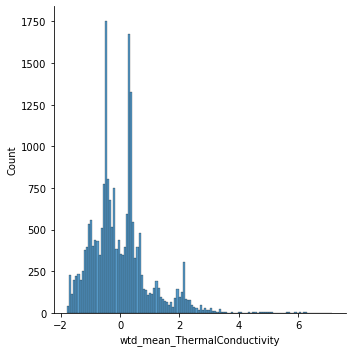

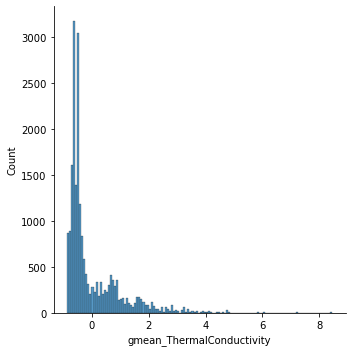

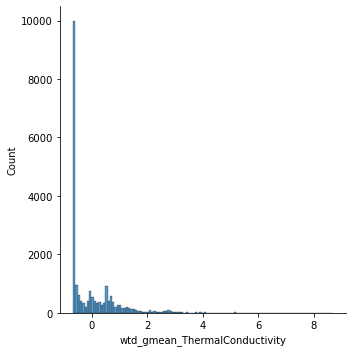

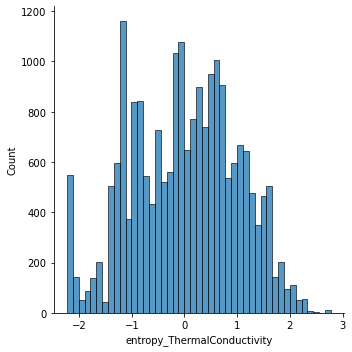

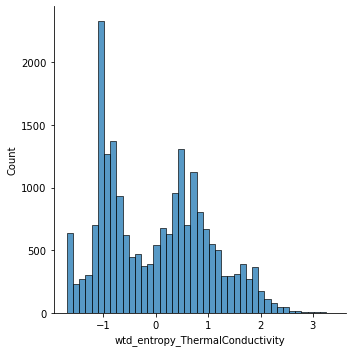

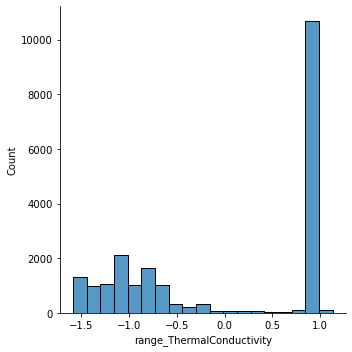

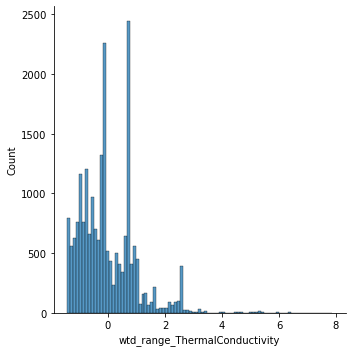

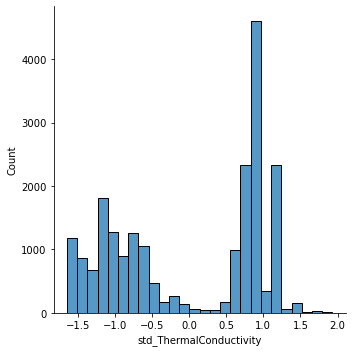

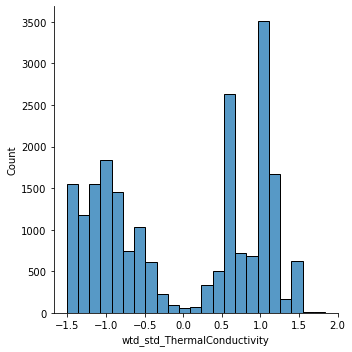

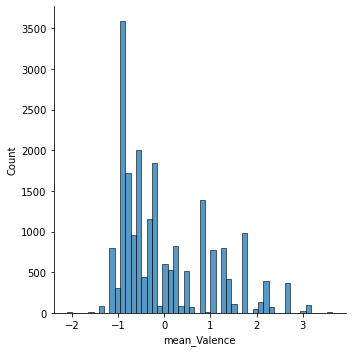

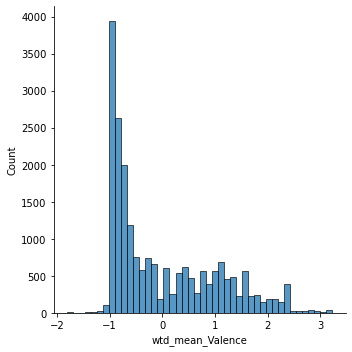

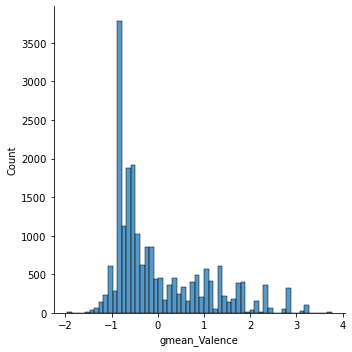

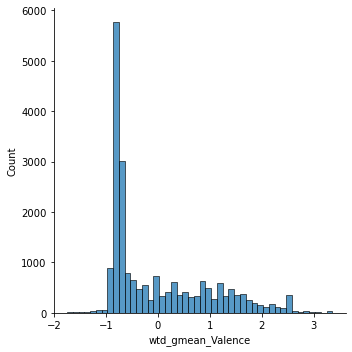

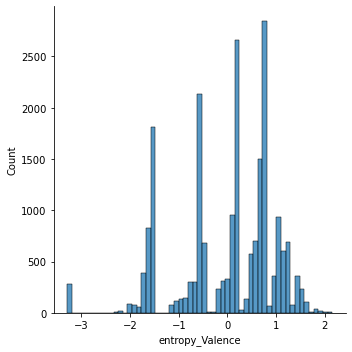

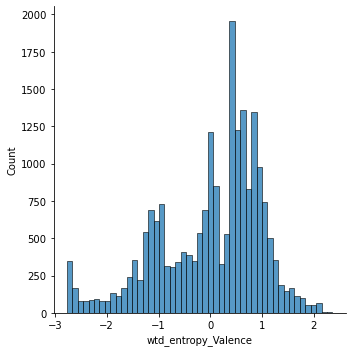

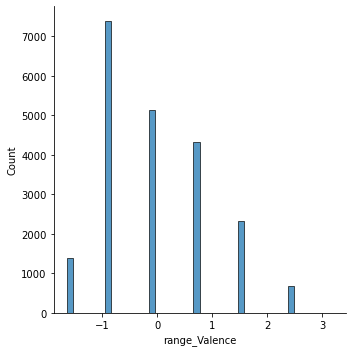

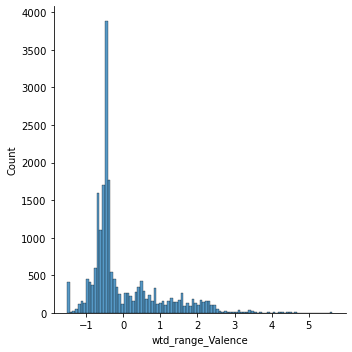

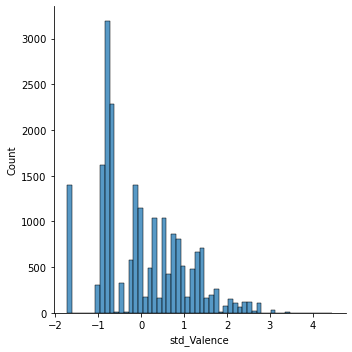

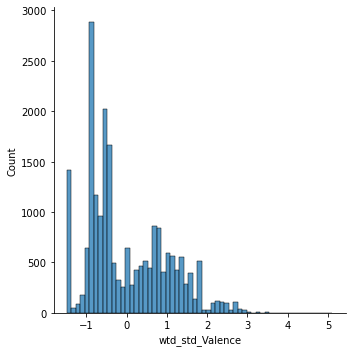

In [38]:
#Re-examine the plots again to see the data normalized. 
for i in X_scaled.columns:
    sns.displot(X_scaled, x = X_scaled[i])
    plt.show()

#### Evaluate two ways of collinearity with VIF and Corr

In [44]:
vif_initial = pd.DataFrame()
vif_initial['Column'] = X_scaled.columns

vif_initial['VIF'] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

print(vif_initial)


C:\Datascience\Anaconda3\envs\ML7331\lib\site-packages\statsmodels\regression\linear_model.py:1738: RuntimeWarning:

invalid value encountered in double_scalars



                  Column         VIF
0                      H    2.003134
1                     He         NaN
2                     Li    1.758200
3                     Be    1.333353
4                      B    1.586689
..                   ...         ...
162  wtd_entropy_Valence  344.018754
163        range_Valence   60.470156
164    wtd_range_Valence   28.798833
165          std_Valence  109.145599
166      wtd_std_Valence   61.723175

[167 rows x 2 columns]


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = NewX_scaled.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(NewX_scaled.values, i)
                          for i in range(len(NewX_scaled.columns))]

print(vif_data)

In [37]:
print(vif_info.sort_values('VIF', ascending=False))

               VIF                  Column
98   366434.672704            wtd_mean_fie
100  327531.852162           wtd_gmean_fie
97   199140.789996                mean_fie
99   178222.300167               gmean_fie
108   84417.929130  wtd_mean_atomic_radius
..             ...                     ...
53             NaN                      Xe
60             NaN                      Pm
83             NaN                      Po
84             NaN                      At
85             NaN                      Rn

[167 rows x 2 columns]


In [40]:
#Examine the correlation matrix of the variables
corr = X_scaled.corr()
corr.style.background_gradient()
corr.style.background_gradient().set_precision(2)

C:\Users\04013953\AppData\Local\Temp\ipykernel_24284\1738449109.py:4: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`

C:\Datascience\Anaconda3\envs\ML7331\lib\site-packages\pandas\io\formats\style.py:3555: RuntimeWarning:

All-NaN slice encountered

C:\Datascience\Anaconda3\envs\ML7331\lib\site-packages\pandas\io\formats\style.py:3556: RuntimeWarning:

All-NaN slice encountered



In [41]:
#Remove variables that are correlated
# columns that start with wtd and gmean
# coumns that contain fie, radius, ThermalConducitivity and Density

X_scaled_clean = X_scaled.loc[:,~corr.columns.str.startswith('wtd')]
X_scaled_clean = X_scaled_clean.loc[:,~X_scaled_clean.columns.str.startswith('gmean')]
X_scaled_clean = X_scaled_clean.loc[:,~X_scaled_clean.columns.str.contains('fie')]
X_scaled_clean = X_scaled_clean.loc[:,~X_scaled_clean.columns.str.contains('radius')]
X_scaled_clean = X_scaled_clean.loc[:,~X_scaled_clean.columns.str.contains('ThermalConductivity')]
X_scaled_clean = X_scaled_clean.loc[:,~X_scaled_clean.columns.str.contains('Density')]

#remove columns based on hih correlation
if 'number_of_elements' in X_scaled_clean:
    del X_scaled_clean['number_of_elements']
if 'std_FusionHeat' in X_scaled_clean:
    del X_scaled_clean['std_FusionHeat']
if 'entropy_ElectronAffinity' in X_scaled_clean:
    del X_scaled_clean['entropy_ElectronAffinity']
if 'entropy_FusionHeat' in X_scaled_clean:
    del X_scaled_clean['entropy_FusionHeat']
if 'entropy_Valence' in X_scaled_clean:
    del X_scaled_clean['entropy_Valence']
if 'std_ElectronAffinity' in X_scaled_clean:
    del X_scaled_clean['std_ElectronAffinity']
if 'std_atomic_mass' in X_scaled_clean:
    del X_scaled_clean['std_atomic_mass']
if 'std_Valence' in X_scaled_clean:
    del X_scaled_clean['std_Valence']
if 'range_FusionHeat' in X_scaled_clean:
    del X_scaled_clean['range_FusionHeat']


In [42]:
#Reevaluate correlation values with the remaining columns
corr_clean = X_scaled_clean.corr()
corr_clean.style.background_gradient()
corr_clean.style.background_gradient().set_precision(2)


C:\Users\04013953\AppData\Local\Temp\ipykernel_24284\3092733779.py:4: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



In [43]:
#Review data frame after the removing correlated variables
X_scaled_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 94 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   H                       21263 non-null  float64
 1   He                      21263 non-null  float64
 2   Li                      21263 non-null  float64
 3   Be                      21263 non-null  float64
 4   B                       21263 non-null  float64
 5   C                       21263 non-null  float64
 6   N                       21263 non-null  float64
 7   O                       21263 non-null  float64
 8   F                       21263 non-null  float64
 9   Ne                      21263 non-null  float64
 10  Na                      21263 non-null  float64
 11  Mg                      21263 non-null  float64
 12  Al                      21263 non-null  float64
 13  Si                      21263 non-null  float64
 14  P                       21263 non-null

#### After clean data of multicollinearity we are left with 94 columns to evaluate our models

## 3) Modeling

#### Model Lasso L1 Regression

In [47]:
#Feature importance. Idea here would be to use L1 Regression to pick out feature importance and those features for L2 Ridge Regression
#For the best results we will cross validate the data first

splits = KFold(n_splits = 5,shuffle = True)
L1_model = Lasso()

#Create error alerts then find the best hyperparameter for the Lasso regression
best = -10000
alpha = np.logspace(-10,10,100)
for i in alpha:
    L1_model.alpha = i
    out = cross_val_score(L1_model,X_scaled_clean,y,scoring = 'neg_mean_squared_error', cv = splits, n_jobs = 3).mean()
    if out > best:
        best = out
        best_alpha = i
print('Best Alpha:',  best_alpha)
print('Best MSE:', best)

Best Alpha: 0.31257158496882353
Best MSE: -395.20159718888834


In [53]:
lasso_best = Lasso(alpha = 0.31)
lasso_best.fit(X_scaled_clean, y)

idx_lasso = np.argpartition(lasso_best.coef_, -10)[-10:]
indices_lasso = idx_lasso[np.argsort((-lasso_best.coef_)[idx_lasso])].tolist()
print('Top 10 coefficients that LASSO chose are:\n', X_scaled_clean.columns[indices_lasso])

Top 10 coefficients that LASSO chose are:
 Index(['Ba', 'Ca', 'Sr', 'range_atomic_mass', 'entropy_atomic_mass', 'Hg',
       'Bi', 'Cu', 'Tl', 'Y'],
      dtype='object')
